# Loading Important Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For exaple, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor #or any model of your choice
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor, plot_importance


import optuna
USE_OPTUNA = False

#To get the root mean squared error
'''
rmse=mean_squared_error(y_true, y_pred, squared=False)
'''

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hackathon-qualification/Starter Notebook.ipynb
/kaggle/input/hackathon-qualification/archive/sample_submission.csv
/kaggle/input/hackathon-qualification/archive/train.csv
/kaggle/input/hackathon-qualification/archive/test.csv


In [2]:
try:
    train = pd.read_csv('/kaggle/input/hackathon-qualification/archive/train.csv')    
    test = pd.read_csv('/kaggle/input/hackathon-qualification/archive/test.csv')
    sub = pd.read_csv('/kaggle/input/hackathon-qualification/archive/sample_submission.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: The file 'train.csv' was not found. Please check the file path.")

Data loaded successfully!


In [3]:
train.shape, test.shape, sub.shape

((188533, 13), (125690, 12), (125690, 2))

In [4]:
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

## Lets Explore - EDA

In [40]:
train.describe()

model_year         milage         price        car_age  \
count  188533.000000  188533.000000  1.885330e+05  188533.000000   
mean     2015.829998   65705.295174  4.387802e+04      10.170002   
std         5.660967   49798.158076  7.881952e+04       5.660967   
min      1974.000000     100.000000  2.000000e+03       2.000000   
25%      2013.000000   24115.000000  1.700000e+04       6.000000   
50%      2017.000000   57785.000000  3.082500e+04       9.000000   
75%      2020.000000   95400.000000  4.990000e+04      13.000000   
max      2024.000000  405000.000000  2.954083e+06      52.000000   

       milage_per_year     horsepower    engine_size      cylinders  
count    188533.000000  188533.000000  188533.000000  188533.000000  
mean       6297.850269     335.631704       3.745859       6.299120  
std        3884.780889     105.421211       1.321110       1.397836  
min           4.761905      70.000000       0.650000       3.000000  
25%        3607.142857     280.000000       3.000000       6.000000  
50%        6047.000000     300.000000       3.500000       6.000000  
75%        8411.764706     395.000000       4.600000       8.000000  
max       78333.333333    1020.000000       8.400000      12.000000

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   brand              188533 non-null  category
 1   model              188533 non-null  category
 2   model_year         188533 non-null  int64   
 3   milage             188533 non-null  int64   
 4   fuel_type          188533 non-null  category
 5   transmission       188533 non-null  category
 6   ext_col            188533 non-null  category
 7   int_col            188533 non-null  category
 8   accident           188533 non-null  category
 9   clean_title        188533 non-null  category
 10  price              188533 non-null  int64   
 11  car_age            188533 non-null  int64   
 12  milage_per_year    188533 non-null  float64 
 13  Is_Luxury_brand    188533 non-null  category
 14  horsepower         188533 non-null  float64 
 15  engine_size        188533 non-null

In [42]:
train.isnull().sum()

brand                0
model                0
model_year           0
milage               0
fuel_type            0
transmission         0
ext_col              0
int_col              0
accident             0
clean_title          0
price                0
car_age              0
milage_per_year      0
Is_Luxury_brand      0
horsepower           0
engine_size          0
cylinders            0
transmission_type    0
dtype: int64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


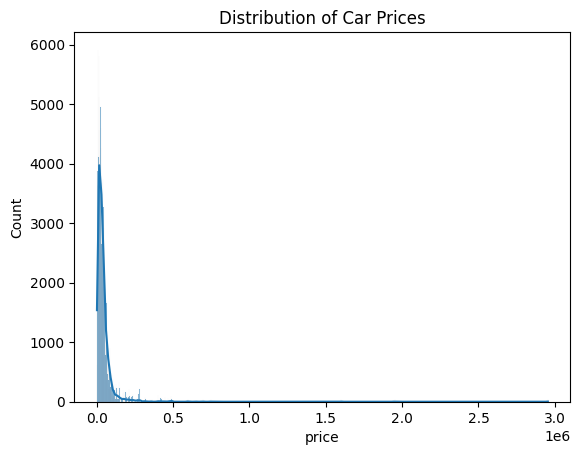

In [32]:
sns.histplot(train['price'], kde=True)
plt.title('Distribution of Car Prices')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


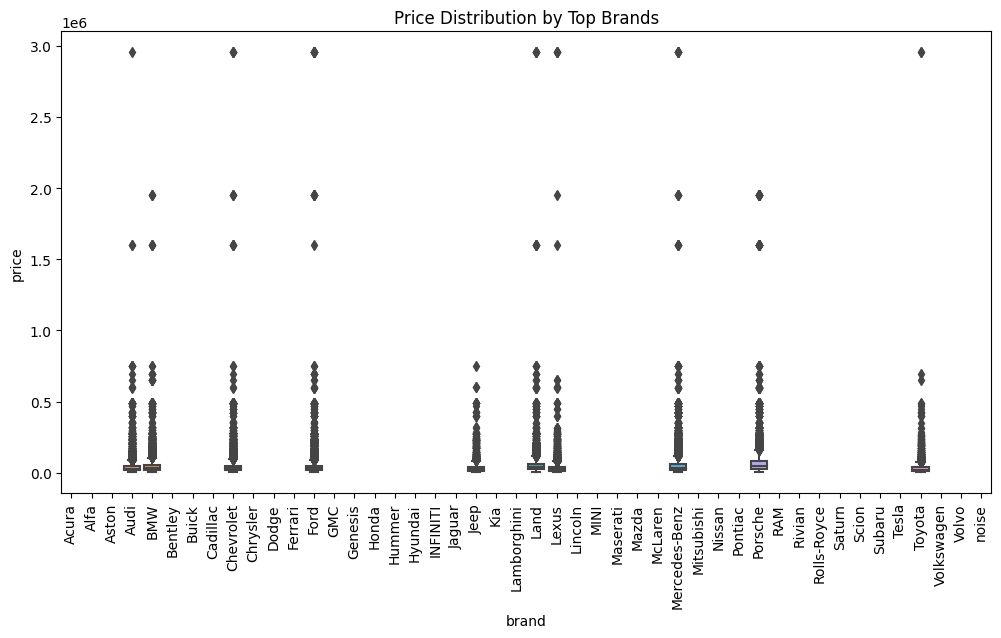

In [37]:
# Get the 10 most frequent brands
top_10_brands = train['brand'].value_counts().nlargest(10).index

# Filter data for top 10 brands
top_10_data = train[train['brand'].isin(top_10_brands)]

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='brand', y='price', data=top_10_data)
plt.xticks(rotation=90)
plt.title('Price Distribution by Top Brands')
plt.show()

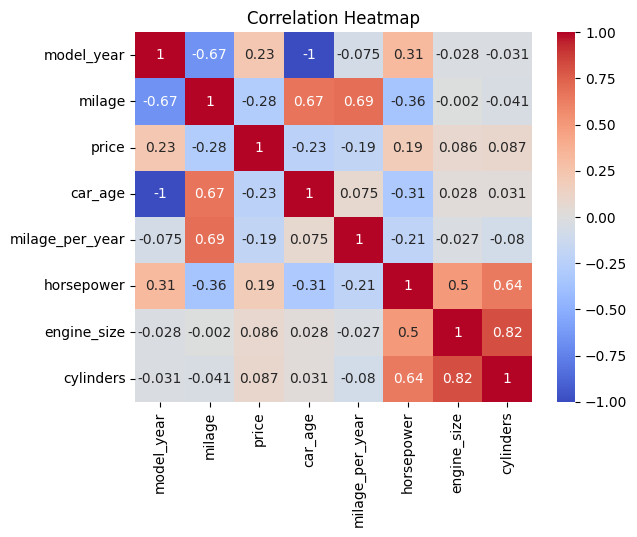

In [39]:
numeric_cols = train.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Feature Engineering

In [5]:
def extract_age_features(df):
    current_year = 2025
    df['car_age'] = current_year - df['model_year'] + 1
    df['milage_per_year'] = df['milage'] / df['car_age']
    # df['milage_with_age'] =  df.groupby('Vehicle_Age')['milage'].transform('mean')
    # df['Mileage_per_Year_with_age'] =  df.groupby('Vehicle_Age')['Mileage_per_Year'].transform('mean')
    return df
    

def extract_luxury(df):
    luxury_brands = [
    "Mercedes-Benz", "BMW", "Audi", "Porsche", "Land Rover", 
    "Lexus", "Cadillac", "Tesla", "INFINITI", "Jaguar", 
    "Bentley", "Maserati", "Lamborghini", "Genesis", "Rolls-Royce", 
    "Ferrari", "McLaren", "Aston Martin", "Lucid", "Lotus", 
    "Karma", "Bugatti", "Maybach"  
    ] 
    
    
    df['Is_Luxury_brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0)
    
    return df

def extract_engine_features(df):
    df = df.copy()
    df['transmission'] = df['transmission'].str.lower()
    df['horsepower'] = df['engine'].str.extract(r'(\d+\.\d+)(?=HP)').astype(float)
    df['engine_size'] = df['engine'].str.extract(r'(\d+\.\d+)(?=L)').astype(float)
    df['cylinders'] = df['engine'].str.extract(r'(\d+)\s(Cylinder|V\d|Straight)')[0].astype(float)
    
    df['transmission_type'] = df['transmission'].apply(lambda x: 
                                                      'manual' if 'm/t' in x or 'manual' in x or 'mt' in x else
                                                      'automatic' if 'a/t' in x or 'automatic' in x or 'at' in x else
                                                      'CVT' if 'CVT' in x else
                                                      'Other')
    return df

In [6]:
 # car and seat color classification from dataset.(powered by GPT)
# based on this statistics (https://www.germaincars.com/most-popular-car-colors/)
def extract_col(df):
    black_colors = [
    'Black', 'Santorini Black Metallic', 'Black Clearcoat', 'Black Obsidian', 
    'Mythos Black Metallic', 'Diamond Black', 'Shadow Black', 'Agate Black Metallic', 
    'Midnight Black Metallic', 'Black Raven', 'Obsidian Black Metallic', 'Magnetite Black Metallic', 
    'Onyx Black', 'Santorin Black', 'DB Black Clearcoat', 'Black Sapphire Metallic', 
    'Ultra Black', 'Magnetic Black', 'Crystal Black Silica', 'Ebony Black', 
    'Jet Black Mica', 'Twilight Black', 'Carbon Black Metallic', 'Beluga Black', 
    'Super Black', 'Phantom Black', 'Black Forest Green', 'Mosaic Black Metallic', 
    'Midnight Black', 'Crystal Black Pearl', 'BLACK', 'Nero Daytona', 
    'Obsidian', 'Black Noir Pearl', 'Aurora Black', 'Vik Black', 
    'Santorini Black', 'Brilliant Black', 'Crystal Black', 'Orca Black Metallic'
    ]

    white_colors = [
    'White', 'Summit White', 'designo Diamond White Metallic', 'Bright White Clearcoat', 
    'Dazzling White', 'White Clearcoat', 'Alpine White', 'Snowflake White Pearl', 
    'Pure White', 'Ibis White', 'Wind Chill Pearl', 'Platinum White Pearl', 
    'Fuji White', 'White Frost Tri-Coat', 'Glacial White Pearl', 'Oxford White', 
    'Eminent White Pearl', 'Ultra White', 'Snow White Pearl', 'designo Diamond White Bright', 
    'Emin White', 'Super White', 'White Diamond Tri-Coat', 'Alta White', 
    'Mineral White', 'Quartz White', 'White Platinum Tri-Coat Metallic', 'Balloon White', 
    'Oryx White Prl', 'Matte White', 'White Knuckle Clearcoat', 'Diamond White', 
    'Pearl White', 'Star White', 'Crystal White Pearl', 'Frozen White', 
    'MANUFAKTUR Diamond White Bright', 'Glacier White'
    ]

    gray_colors = [
    'Gray', 'Granite Crystal Clearcoat Metallic', 'Magnetic Gray Clearcoat', 'Eiger Grey Metallic', 
    'Nebula Gray Pearl', 'Daytona Gray', 'Shadow Gray Metallic', 'Typhoon Gray', 
    'Magnetite Gray Metallic', 'Daytona Gray Pearl Effect', 'Magnetic Metallic', 'Dark Graphite Metallic', 
    'Quartzite Grey Metallic', 'Eiger Grey', 'Graphite Grey Metallic', 'Donington Grey Metallic', 
    'Daytona Gray Pearl Effect w/ Black Roof', 'Hampton Gray', 'Typhoon Gray Metallic', 'Stone Gray Metallic', 
    'Nightfall Gray Metallic', 'Brands Hatch Gray Metallic', 'Machine Gray Metallic', 'Carbonized Gray Metallic', 
    'Chronos Gray', 'Baltic Gray', 'Dark Slate Metallic', 'Arctic Gray Metallic', 
    'Platinum Gray Metallic', 'Granite Crystal Metallic Clearcoat', 'Gun Metallic', 'Thunder Gray', 
    'Dark Gray Metallic', 'Portofino Gray', 'Polymetal Gray Metallic', 'Graphite Grey', 
    'Arctic Gray Metallic', 'Platinum Gray Metallic', 'Volcano Grey Metallic', 'Ironman Silver', 
    'Thunder Gray', 'Aventurine Green Metallic'
    ]

    silver_colors = [
    'Silver', 'Silver Ice Metallic', 'Sparkling Silver', 'Sonic Silver Metallic', 
    'Atomic Silver', 'Titanium Silver', 'Brilliant Silver Metallic', 'Glacier Silver Metallic', 
    'Silver Zynith', 'Ingot Silver Metallic', 'Tungsten Metallic', 'Selenite Gray Metallic', 
    'Cirrus Silver Metallic', 'Silver Radiance', 'Iconic Silver Metallic', 'Billet Silver Metallic Clearcoat', 
    'Rift Metallic', 'Florett Silver', 'Ice Silver Metallic', 'Iridium Silver Metallic', 
    'Indus Silver', 'Silver Flare Metallic', 'Silver Mist', 'Quicksilver Metallic', 
    'Silky Silver', 'Reflex Silver', 'Ironman Silver'
    ]

    red_colors = [
    'Red', 'Cameron Green', 'Tim David', 'Firecracker Red Clearcoat', 'Ruby Flare Pearl', 
    'Firenze Red', 'Tango Red Metallic', 'Siren Red Tintcoat', 'Delmonico Red Pearlcoat', 
    'Passion Red', 'Infrared Tintcoat', 'Red Quartz Tintcoat', 'Flame Red Clearcoat', 
    'Velvet Red Pearlcoat', 'Matador Red Mica', 'Rosso Corsa', 'Octane Red Pearlcoat', 
    'Remington Red Metallic', 'Hyper Red', 'Cayenne Red Tintcoat', 'Radiant Red Metallic II', 
    'Redline Red', 'Scarlet Ember', 'Ruby Red Metallic Tinted Clearcoat', 'Crimson Red Tintcoat', 
    'Red Multi', 'Rosso', 'Jupiter Red', 'Red Obsession', 'Ember Pearlcoat', 
    'Sangria Red', 'Remington Red Metallic'
    ]

    blue_colors = [
    'Deep Crystal Blue Mica',
    'Patriot Blue Pearlcoat',
    'Blue',
    'Antimatter Blue Metallic',
    'Blu',
    'Shoreline Blue Pearl',
    'Gentian Blue Metallic',
    'Phytonic Blue Metallic',
    'Horizon Blue',
    'Northsky Blue Metallic',
    'Caspian Blue',
    'Pacific Blue Metallic',
    'Vega Blue',
    'Electric Blue Metallic',
    'Glacier Blue Metallic',
    'Blue Metallic',
    'Twilight Blue Metallic',
    'Anodized Blue Metallic',
    'Blue Caelum',
    'Midnight Blue Metallic'
    ]
    
    def condition(color):
        if color in black_colors:
            return "black"
        elif color in white_colors:
            return "white"
        elif color in gray_colors:
            return "gray"
        elif color in silver_colors:
            return "silver"
        elif color in red_colors:
            return "red"
        elif color in blue_colors:
            return "blue"
        else:
            return "uncommon"
    
    df['ext_col'] = df['ext_col'].apply(condition)
    
    
    Black= [
        'Black', 'Jet Black', 'BLACK', 'Global Black', 'Black Onyx',
        'Sardar Brown', 'Black/Gun Metal', 'Charcoal Black', 
        'Ebony Black', 'Carbon Black', 'Black w/Red Stitching',
        'Blk', 'Obsidian Black', 'Black/Graphite', 'Black/Saddle Brown',
        'Black / Brown', 'Titan Black', 'AMG Black', 'Black / Gray',
        'Black / Stone Grey', 'Black / Express Red', 'Black / Saddle',
        'Black / Pimento', 'Ebony', 'Ebony / Ebony Accents',
        'Ebony/Light Oyster Stitch'
    ]
    White= [
        'White', 'Grace White', 'Ivory / Ebony', 'WHITE'
    ]
    Gray= [
        'Gray', 'Dark Gray', 'Light Gray', 'Medium Gray', 
        'Medium Earth Gray', 'Slate', 'Charcoal', 'Graphite',
        'Ebony.', 'Medium Light Camel', 'Mistral Gray / Raven',
        'Medium Ash Gray', 'Light Platinum / Jet Black', 
        'Parchment', 'Parchment.', 'Graystone', 'Ash'
    ]
    Beige= [
        'Beige', 'Canberra Beige', 'Macchiato Beige/Black', 
        'Whisper Beige', 'Silk Beige/Espresso Brown', 'Saiga Beige',
        'Sand Beige', 'Silk Beige/Black', 'Cappuccino', 
        'Pearl Beige', 'Tan/Ebony/Ebony', 'Tan/Ebony', 
        'Camel', 'Light Titanium'
    ]
    Brown= [
        'Brown', 'Chestnut', 'Caramel', 'Saddle Brown',
        'Walnut', 'Espresso', 'Dark Galvanized', 'Cocoa / Dune', 
        'Giallo Taurus / Nero Ade', 'Mocha', 'Mountain Brown',
        'Brandy', 'Roast', 'Sahara Tan', 'Nougat Brown',
        'Medium Dark Slate', 'Medium Stone', 'Tension'
    ]

    Red=[
        'Red', 'Rioja Red', 'Adrenaline Red', 'Magma Red',
        'Pimento Red w/Ebony', 'Classic Red', 'Hotspur', 
        'Red/Black', 'Black / Express Red'
    ]
    
    def condition_int(color):
        if color in Black:
            return "black"
        elif color in White:
            return "white"
        elif color in Gray:
            return "gray"
        elif color in Beige:
            return "beige"
        elif color in Brown:
            return "brown"
        elif color in Red:
            return "red"
        else:
            return "uncommon"
    
    df['int_col'] = df['int_col'].apply(condition_int)
    
    return df

In [7]:
def update(df, t=100):
    # Handle categorical columns
    cat_c = df.select_dtypes(include=['category', 'object']).columns
    for col in cat_c:
        # Replace rare values with "noise"
        freq = df[col].value_counts(dropna=False)
        rare_values = freq[freq < t].index
        df[col] = df[col].where(~df[col].isin(rare_values), "noise")
        
        # Fill missing values
        df[col] = df[col].fillna("missing").astype("category")
    
    # Handle numeric columns
    numeric = df.select_dtypes(include=['int', 'float']).columns
    for col in numeric:
        df[col] = df[col].fillna(df[col].mode().iloc[0])
    
    # Special treatment
    if "Is_Luxury_brand" in df.columns:
        df["Is_Luxury_brand"] = df["Is_Luxury_brand"].astype("category")
    
    return df

In [8]:
%%time

train = extract_age_features(train)
train = extract_col(train)
train = extract_luxury(train)
train = extract_engine_features(train)


train = update(train)

test = extract_age_features(test)
test = extract_col(test)
test = extract_luxury(test)
test = extract_engine_features(test)


test = update(test)

train = train.drop(['engine'], axis=1)
test = test.drop('engine', axis=1)

CPU times: user 3.53 s, sys: 155 ms, total: 3.68 s
Wall time: 3.68 s


In [9]:
print(train.dtypes)
print(train.isna().sum())

brand                category
model                category
model_year              int64
milage                  int64
fuel_type            category
transmission         category
ext_col              category
int_col              category
accident             category
clean_title          category
price                   int64
car_age                 int64
milage_per_year       float64
Is_Luxury_brand      category
horsepower            float64
engine_size           float64
cylinders             float64
transmission_type    category
dtype: object
brand                0
model                0
model_year           0
milage               0
fuel_type            0
transmission         0
ext_col              0
int_col              0
accident             0
clean_title          0
price                0
car_age              0
milage_per_year      0
Is_Luxury_brand      0
horsepower           0
engine_size          0
cylinders            0
transmission_type    0
dtype: int64


In [10]:
train.head()

brand          model  model_year  milage      fuel_type  \
0           MINI  Cooper S Base        2007  213000       Gasoline   
1        Lincoln          noise        2002  143250       Gasoline   
2      Chevrolet          noise        2002  136731  E85 Flex Fuel   
3        Genesis          noise        2017   19500       Gasoline   
4  Mercedes-Benz    Metris Base        2021    7388       Gasoline   

                     transmission   ext_col int_col  \
0                             a/t  uncommon    gray   
1                             a/t    silver   beige   
2                             a/t      blue    gray   
3  transmission w/dual shift mode     black   black   
4                     7-speed a/t     black   beige   

                                 accident clean_title  price  car_age  \
0                           None reported         Yes   4200       19   
1  At least 1 accident or damage reported         Yes   4999       24   
2                           None reported         Yes  13900       24   
3                           None reported         Yes  45000        9   
4                           None reported         Yes  97500        5   

   milage_per_year Is_Luxury_brand  horsepower  engine_size  cylinders  \
0     11210.526316               0       172.0          1.6        4.0   
1      5968.750000               0       252.0          3.9        8.0   
2      5697.125000               0       320.0          5.3        8.0   
3      2166.666667               1       420.0          5.0        8.0   
4      1477.600000               1       208.0          2.0        4.0   

  transmission_type  
0         automatic  
1         automatic  
2         automatic  
3             Other  
4         automatic

In [11]:
X = train.drop('price', axis=1)
y = train['price']

# Building and Stacking

In [13]:
#callbacks = [log_evaluation(period=300), early_stopping(stopping_rounds=200)]


cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

## Finding Best Params

In [ ]:
# ================================
# LightGBM objective
# ================================
def objective_lgb(trial):
    lgb_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'n_estimators': 1000,
        'random_state': 42
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        model = lgb.train(
            lgb_params,
            train_data,
            valid_sets=[val_data],
            callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
        )

        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)


# ================================
# CatBoost objective
# ================================
def objective_cat(trial):
    cat_params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'depth': trial.suggest_int('depth', 5, 16),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 10.0, log=True),
        'iterations': 1000,
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'random_seed': 42,
        'task_type': 'GPU',  
        'early_stopping_rounds': 200,
        'verbose': 0
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores_cat = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        train_pool = Pool(X_train, y_train, cat_features=cat_cols)
        val_pool = Pool(X_val, y_val, cat_features=cat_cols)

        model_cat = CatBoostRegressor(**cat_params)
        model_cat.fit(train_pool, eval_set=val_pool, verbose=False)

        y_pred_cat = model_cat.predict(X_val)
        rmse_cat = np.sqrt(mean_squared_error(y_val, y_pred_cat))
        rmse_scores_cat.append(rmse_cat)

    return np.mean(rmse_scores_cat)


# ================================
# Run Optuna studies
# ================================
USE_OPTUNA = True

if USE_OPTUNA:
    # LightGBM
    study_lgb = optuna.create_study(direction='minimize')
    study_lgb.optimize(objective_lgb, n_trials=20)

    print("Best LGBM Parameters: ", study_lgb.best_params)
    print("Best LGBM RMSE: ", study_lgb.best_value)

In [19]:
%%time

# CatBoost
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=20)

print("Best CatBoost Parameters: ", study_cat.best_params)
print("Best CatBoost RMSE: ", study_cat.best_value)

[I 2025-09-14 20:15:42,465] A new study created in memory with name: no-name-8054c90e-6672-45f6-8ac8-b6edb4db84ab
[I 2025-09-14 20:48:24,485] Trial 0 finished with value: 75496.45415037866 and parameters: {'learning_rate': 0.000589576356736181, 'depth': 15, 'l2_leaf_reg': 5.8141599288968795, 'random_strength': 53}. Best is trial 0 with value: 75496.45415037866.
[I 2025-09-14 20:55:19,464] Trial 1 finished with value: 77407.27508962258 and parameters: {'learning_rate': 0.00019229865381762773, 'depth': 12, 'l2_leaf_reg': 0.4301798014243896, 'random_strength': 75}. Best is trial 0 with value: 75496.45415037866.
[I 2025-09-14 20:56:33,507] Trial 2 finished with value: 72752.70451196711 and parameters: {'learning_rate': 0.044180056783540055, 'depth': 5, 'l2_leaf_reg': 0.004041161586465245, 'random_strength': 4}. Best is trial 2 with value: 72752.70451196711.
[I 2025-09-14 21:02:17,408] Trial 3 finished with value: 72731.38012440005 and parameters: {'learning_rate': 0.021895593683070595, 'de

KeyboardInterrupt: 

In [14]:
print("LightGBM best RMSE:", study_lgb.best_value)

LightGBM best RMSE: 72613.9208029544


In [ ]:
print("LightGBM best RMSE:", study_lgb.best_value)
print("CatBoost best RMSE:", study_cat.best_value)

if study_lgb.best_value < study_cat.best_value:
    print("✅ LightGBM performed better")
else:
    print("✅ CatBoost performed better")

LightGBM best RMSE: 72613.9208029544
CatBoost best RMSE: 72731.38012440005
✅ LightGBM performed better


In [ ]:
best_lgb = lgb.LGBMRegressor(**study_lgb.best_params)
best_lgb.fit(X, y)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1448
[LightGBM] [Info] Number of data points in the train set: 188533, number of used features: 17
[LightGBM] [Info] Start training from score 43878.016178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(colsample_bytree=0.20526051907168863,
              learning_rate=0.02706609169905322, max_depth=35, num_leaves=22,
              reg_alpha=0.0004916074412830571,
              reg_lambda=0.00011298045471980683, subsample=0.9931898334605979)

In [ ]:
%%time
best_cat = CatBoostRegressor(**study_cat.best_params, verbose=0)
best_cat.fit(X, y, cat_features=cat_cols)

CPU times: user 29min 51s, sys: 42.2 s, total: 30min 34s
Wall time: 7min 49s


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

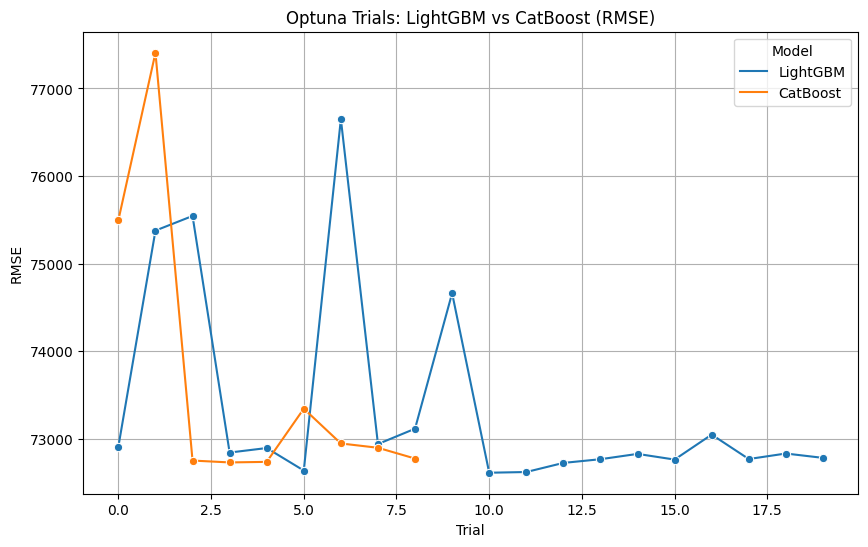

In [27]:
# Extract results
lgb_results = pd.DataFrame({
    "trial": range(len(study_lgb.trials)),
    "rmse": [t.value for t in study_lgb.trials],
    "model": "LightGBM"
})

cat_results = pd.DataFrame({
    "trial": range(len(study_cat.trials)),
    "rmse": [t.value for t in study_cat.trials],
    "model": "CatBoost"
})

results = pd.concat([lgb_results, cat_results], ignore_index=True)


# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x="trial", y="rmse", hue="model", marker="o")
plt.title("Optuna Trials: LightGBM vs CatBoost (RMSE)")
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.legend(title="Model")
plt.grid(True)
plt.show()

In [29]:
# Predictions
LGBM_preds = best_lgb.predict(test)
CAT_preds  = best_cat.predict(test)

test_preds = 0.7 * LGBM_preds + 0.3 * CAT_preds

In [26]:
results

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


trial          rmse     model
0       0  72912.096058  LightGBM
1       1  75377.427440  LightGBM
2       2  75544.285830  LightGBM
3       3  72844.121316  LightGBM
4       4  72895.624161  LightGBM
5       5  72638.779439  LightGBM
6       6  76649.797165  LightGBM
7       7  72941.149950  LightGBM
8       8  73116.306078  LightGBM
9       9  74662.616169  LightGBM
10     10  72613.920803  LightGBM
11     11  72621.842431  LightGBM
12     12  72725.826077  LightGBM
13     13  72768.070687  LightGBM
14     14  72828.737327  LightGBM
15     15  72764.010316  LightGBM
16     16  73049.050746  LightGBM
17     17  72770.161698  LightGBM
18     18  72833.026181  LightGBM
19     19  72783.467750  LightGBM
0       0  75496.454150  CatBoost
1       1  77407.275090  CatBoost
2       2  72752.704512  CatBoost
3       3  72731.380124  CatBoost
4       4  72737.784500  CatBoost
5       5  73344.805882  CatBoost
6       6  72947.871306  CatBoost
7       7  72898.657349  CatBoost
8       8  72775.664474  CatBoost
9       9           NaN  CatBoost

## Submissions

In [30]:
sub.head()

id      price
0  188533  43878.016
1  188534  43878.016
2  188535  43878.016
3  188536  43878.016
4  188537  43878.016

In [31]:
sub['price'] = test_preds
sub.to_csv("sub2.csv", index=False)
sub.head()

id         price
0  188533  19711.587550
1  188534  72544.166797
2  188535  56258.763163
3  188536  39207.928139
4  188537  30441.104491